In [109]:
import os
import random
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Lambda
)
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score


In [110]:
# Global config
IMG_SIZE = 112
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_DIR = "/kaggle/input/datasetsforrestnet/ThirdLap"


In [111]:
def parse_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [112]:
def build_train_val_datasets(root_dir, val_ratio=0.1):
    class_names = sorted(
        [d for d in os.listdir(root_dir)
         if os.path.isdir(os.path.join(root_dir, d))]
    )

    num_classes = len(class_names)
    print(f"Total identities: {num_classes}")

    train_paths, train_labels = [], []
    val_paths, val_labels = [], []

    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(root_dir, cls)
        images = [
            os.path.join(cls_dir, img)
            for img in os.listdir(cls_dir)
            if img.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        random.shuffle(images)
        split = int(len(images) * (1 - val_ratio))

        train_imgs = images[:split]
        val_imgs = images[split:]

        train_paths.extend(train_imgs)
        train_labels.extend([label] * len(train_imgs))

        val_paths.extend(val_imgs)
        val_labels.extend([label] * len(val_imgs))

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.shuffle(20000)
    train_ds = train_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return train_ds, val_ds, num_classes


In [113]:
train_ds, val_ds, num_classes = build_train_val_datasets(DATASET_DIR)


Total identities: 540


In [114]:
def l2_norm(x):
    return tf.nn.l2_normalize(x, axis=1)


In [115]:
def build_resnet_embedding():
    inputs = Input(shape=(112, 112, 3), name="input_image")

    base = ResNet50(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        pooling="avg"
    )

    x = BatchNormalization()(base.output)
    x = Dense(512, use_bias=False)(x)
    x = BatchNormalization()(x)
    embeddings = Lambda(l2_norm, name="embeddings")(x)

    return Model(inputs, embeddings, name="ResNet50_Embedding")


In [1]:
class ArcFaceTrainer(tf.keras.Model):
    def __init__(self, backbone, arcface, **kwargs):
        super().__init__(**kwargs)
        self.backbone = backbone
        self.arcface = arcface
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            embeddings = self.backbone(x, training=True)
            logits = self.arcface(embeddings, y)

            loss = self.compute_loss(
                x=x,
                y=y,
                y_pred=logits,
                training=True
            )

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(y, logits)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }

    def test_step(self, data):
        x, y = data

        embeddings = self.backbone(x, training=False)
        logits = self.arcface(embeddings, y)

        loss = self.compute_loss(
            x=x,
            y=y,
            y_pred=logits,
            training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(y, logits)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }


NameError: name 'tf' is not defined

In [117]:
backbone = build_resnet_embedding()
arcface = ArcFace(num_classes)
model = ArcFaceModel(backbone, arcface)


In [118]:
model = ArcFaceTrainer(backbone, arcface)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

model.build((None, 112, 112, 3))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'arc_face_trainer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [119]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="arcface_resnet50_best.weights.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks,
    verbose=1class ArcFaceTrainer(tf.keras.Model):
    def __init__(self, backbone, arcface, **kwargs):
        super().__init__(**kwargs)
        self.backbone = backbone
        self.arcface = arcface
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            embeddings = self.backbone(images, training=True)
            logits = self.arcface(embeddings, labels)
            loss = self.compiled_loss(labels, logits)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(labels, logits)

        return {"loss": self.loss_tracker.result(),
                "accuracy": self.acc_tracker.result()}

    def test_step(self, data):
        images, labels = data

        embeddings = self.backbone(images, training=False)
        logits = self.arcface(embeddings, labels)
        loss = self.compiled_loss(labels, logits)

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(labels, logits)

        return {"loss": self.loss_tracker.result(),
                "accuracy": self.acc_tracker.result()}

)


Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:671: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


4532/4532 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1171 - loss: 25.1788
Epoch 1: val_loss improved from inf to 28.56816, saving model to arcface_resnet50_best.weights.h5
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 574s 116ms/step - accuracy: 0.1171 - loss: 25.1779 - val_accuracy: 0.1847 - val_loss: 28.5682 - learning_rate: 1.0000e-04
Epoch 2/25
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4953 - loss: 11.7622
Epoch 2: val_loss improved from 28.56816 to 20.04680, saving model to arcface_resnet50_best.weights.h5
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 500s 110ms/step - accuracy: 0.4953 - loss: 11.7619 - val_accuracy: 0.3441 - val_loss: 20.0468 - learning_rate: 1.0000e-04
Epoch 3/25
4531/4532 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6915 - loss: 6.7924
Epoch 3: val_loss improved from 20.04680 to 16.49994, saving model to arcface_resnet50_best.weights.h5
4532/4532 ━━━━━━━━━━━━━━━━━━━━ 499s 110ms/step - accuracy: 0.6915 - loss: 6.7923 - val_accuracy: 0.4419 - val_loss: 16.4999 - lea

In [123]:
def extract_embeddings(backbone, dataset):
    embs, labels = [], []
    for images, lbls in dataset:
        emb = backbone(images, training=False)
        embs.append(emb.numpy())
        labels.append(lbls.numpy())
    return np.vstack(embs), np.hstack(labels)


In [121]:
embeddings, labels = extract_embeddings(backbone, val_ds)

similarity = cosine_similarity(embeddings)
same = labels[:, None] == labels[None, :]

auc = roc_auc_score(same.flatten(), similarity.flatten())
print("Verification ROC-AUC:", auc)


Verification ROC-AUC: 0.9772544853211012


In [122]:
np.fill_diagonal(similarity, -1)
preds = labels[np.argmax(similarity, axis=1)]
top1_acc = np.mean(preds == labels)

print("Top-1 Identification Accuracy:", top1_acc)


Top-1 Identification Accuracy: 0.9172741875695045


In [124]:
# embedding model for inference
embedding_model = tf.keras.Model(
    inputs=backbone.input,
    outputs=backbone.output,
    name="embedding_model"
)


In [125]:
import numpy as np
from tqdm import tqdm

def extract_embeddings(model, dataset):
    embeddings = []
    labels = []

    for images, lbls in tqdm(dataset):
        emb = model(images, training=False)
        emb = tf.math.l2_normalize(emb, axis=1)
        embeddings.append(emb.numpy())
        labels.append(lbls.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels


val_embeddings, val_labels = extract_embeddings(embedding_model, val_ds)


100%|██████████| 506/506 [01:47<00:00,  4.70it/s]


In [126]:
from itertools import combinations
import random

def create_pairs(embeddings, labels, max_pairs=100000):
    pairs = []
    pair_labels = []

    label_to_indices = {}
    for idx, lbl in enumerate(labels):
        label_to_indices.setdefault(lbl, []).append(idx)

    # Positive pairs
    for lbl, idxs in label_to_indices.items():
        for i, j in combinations(idxs, 2):
            pairs.append((embeddings[i], embeddings[j]))
            pair_labels.append(1)
            if len(pairs) >= max_pairs:
                break

    # Negative pairs
    all_labels = list(label_to_indices.keys())
    while len(pairs) < 2 * max_pairs:
        l1, l2 = random.sample(all_labels, 2)
        i = random.choice(label_to_indices[l1])
        j = random.choice(label_to_indices[l2])
        pairs.append((embeddings[i], embeddings[j]))
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)


pairs, pair_labels = create_pairs(val_embeddings, val_labels)


In [127]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_scores(pairs):
    scores = []
    for emb1, emb2 in pairs:
        score = cosine_similarity(
            emb1.reshape(1, -1),
            emb2.reshape(1, -1)
        )[0][0]
        scores.append(score)
    return np.array(scores)


scores = cosine_scores(pairs)


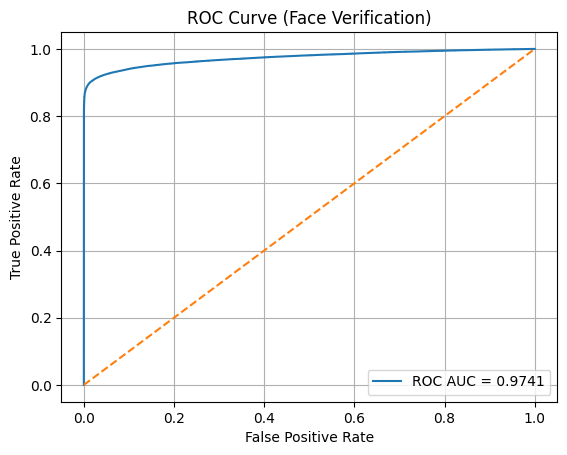

In [128]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, roc_thresholds = roc_curve(pair_labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Face Verification)")
plt.legend()
plt.grid()
plt.show()



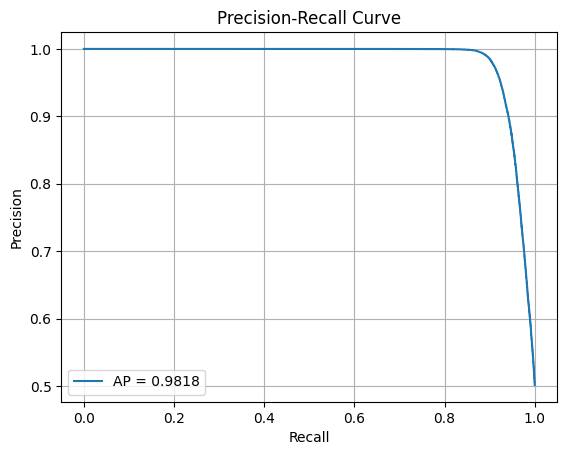

In [129]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, pr_thresholds = precision_recall_curve(pair_labels, scores)
ap = average_precision_score(pair_labels, scores)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


In [130]:
from sklearn.metrics import f1_score

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)

best_threshold = pr_thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")


Best Threshold: 0.1519
Best F1 Score: 0.9413


In [133]:
import numpy as np
from sklearn.metrics import roc_curve

def tar_at_far(y_true, scores, far_targets=[1e-3, 1e-4]):
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    results = {}

    for far in far_targets:
        idx = np.where(fpr <= far)[0]
        if len(idx) > 0:
            results[far] = tpr[idx[-1]]
        else:
            results[far] = 0.0

    return results


tar_results = tar_at_far(pair_labels, scores)
for far, tar in tar_results.items():
    print(f"TAR @ FAR={far}: {tar:.4f}")


TAR @ FAR=0.001: 0.8513
TAR @ FAR=0.0001: 0.7402


In [134]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(pair_labels, scores)

f1 = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1)

best_threshold = thresholds[best_idx]
best_f1 = f1[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")


Best Threshold: 0.1519
Best F1 Score: 0.9413


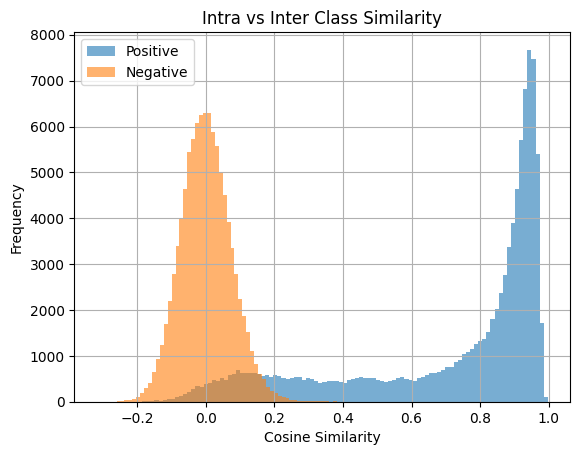

In [135]:
    import matplotlib.pyplot as plt
    
    pos_scores = scores[pair_labels == 1]
    neg_scores = scores[pair_labels == 0]
    
    plt.figure()
    plt.hist(pos_scores, bins=100, alpha=0.6, label="Positive")
    plt.hist(neg_scores, bins=100, alpha=0.6, label="Negative")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Intra vs Inter Class Similarity")
    plt.grid()
    plt.show()


In [136]:
def threshold_at_far(y_true, scores, target_far=1e-3):
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    idx = np.where(fpr <= target_far)[0][-1]
    return thresholds[idx], tpr[idx]

thr, tar = threshold_at_far(pair_labels, scores, 1e-3)
print(f"Threshold @ FAR=1e-3: {thr:.4f}, TAR={tar:.4f}")


Threshold @ FAR=1e-3: 0.2809, TAR=0.8513


In [140]:
def extract_pair_scores_tta(model, pair_ds):
    scores = []
    labels = []

    for (img1, img2), y in pair_ds:
        # embeddings
        e1a = model(img1, training=False)
        e1b = model(tf.image.flip_left_right(img1), training=False)
        e1 = tf.math.l2_normalize((e1a + e1b) / 2.0, axis=1)

        e2a = model(img2, training=False)
        e2b = model(tf.image.flip_left_right(img2), training=False)
        e2 = tf.math.l2_normalize((e2a + e2b) / 2.0, axis=1)

        # cosine similarity
        sim = tf.reduce_sum(e1 * e2, axis=1)

        scores.append(sim.numpy())
        labels.append(y.numpy())

    return np.concatenate(scores), np.concatenate(labels)


In [ ]:
embeddings, labels = extract_embeddings_tta(model, val_ds)


In [144]:
import os

save_dir = "/kaggle/workingoutput/RestNet"
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, "FaceModel.keras"))


In [145]:
!ls  "/kaggle/output/RestNet"

FaceModel.keras
